## Import the required packages

In [1]:
# import required packages
import matplotlib.pyplot as plt
import numpy as np
import json
import seaborn as sns
import pandas as pd

from sympy import *
import itertools
from sklearn.metrics import r2_score

# the packages for EIS ECMs analysis
import impedance
from impedance import preprocessing
from impedance.validation import linKK

# the packages for visualization
import cv2
from PIL import Image
import re

# the packages for peak fitting
import glob
import os
from os.path import basename
from scipy.optimize import curve_fit
import sys

In [2]:
# set the parameters for plots
plt.rcParams['figure.figsize']=(19.6, 10.8)

## Load the EIS data

In [7]:
# For Robert's Data:
data = "rbnb3p8_Test_4_Char_GEIS_9_raw.json"
f = open(data)
data = json.load(f)

In [8]:
df = pd.DataFrame(data)
df

,GEIS
Ece,"[-0.268477, -0.269202, -0.269639, -0.26984, -0..."
Ece_bar,"[-2147483648.0, -536870912.0, 1073741824.0, -2..."
Ewe,"[1.58075, 1.59453, 1.59925, 1.60055, 1.6013, 1..."
Ewe_bar,"[0.00123485, 0.00122957, 0.00123855, 0.0009437..."
I,"[0.000702716, 0.000702849, 0.00070282, 0.00070..."
I_bar,"[6.62439e-05, 6.6714e-05, 6.79687e-05, 5.11851..."
Ice_bar,"[6.62384e-05, 6.67107e-05, 6.79665e-05, 5.1184..."
freq,"[100016.0, 79125.0, 62601.6, 49539.1, 39195.3,..."
meta,"[Tue Jan 4 14:24:10 2022, Sequence time = 118..."
phase_Zce,"[0.0493015, 0.00483781, -0.0222723, -0.0498514..."


In [5]:
# For Parisa's Data
data = pd.read_excel("Parisa_2022-01-28-MEA #3_02_PEIS_C01.xlsx")

In [6]:
new_col = ['freq/Hz', 'Re(Z)/Ohm',"=-@Im(Z)/@Ohm" , '|Z|/Ohm',"Phase(Z)/deg","time/s","<Ewe>/V","<I>/mA","Cs/µF", "Cp/µF","cycle number","I Range","|Ewe|/V","|I|/A","Ns","(Q-Qo)/mA.h","Re(Y)/Ohm-1","Im(Y)/Ohm-1","|Y|/Ohm-1","Phase(Y)/deg","dq/mA.h"]
data.columns = new_col
data[62:132]

,freq/Hz,Re(Z)/Ohm,=-@Im(Z)/@Ohm,|Z|/Ohm,Phase(Z)/deg,time/s,<Ewe>/V,<I>/mA,Cs/µF,Cp/µF,...,I Range,|Ewe|/V,|I|/A,Ns,(Q-Qo)/mA.h,Re(Y)/Ohm-1,Im(Y)/Ohm-1,|Y|/Ohm-1,Phase(Y)/deg,dq/mA.h
62,1.00002e+06,0.671438,-3.174957,3.24518,78.0591,2948.18,-3.00026,-374.248,-0.0501273,-0.0479814,...,7,6.42706e-05,1.9805e-05,0,-45259.4,0.0637572,-0.301482,0.308149,-78.0591,-45259.4
63,791679,2.5599,-0.638218,2.63826,13.9992,2948.63,-3.00078,-376.371,-0.314994,-0.0184334,...,7,4.01364e-05,1.52132e-05,0,-45259.5,0.36778,-0.0916925,0.379038,-13.9992,-0.0475503
64,626763,-0.195147,-1.190079,1.20597,99.3124,2949.09,-3.00092,-377.417,-0.213374,-0.207787,...,7,5.23888e-05,4.34411e-05,0,-45259.5,-0.13418,-0.818278,0.829206,-99.3124,-0.0476673
65,496196,-0.100336,-0.696363,0.703554,98.1991,2949.81,-3.00097,-378.382,-0.460608,-0.45124,...,7,0.000209579,0.000297886,0,-45259.6,-0.202704,-1.40683,1.42135,-98.1991,-0.0773206
66,392824,0.066372,-0.545445,0.549468,83.0621,2950.25,-3.00097,-378.765,-0.742799,-0.731961,...,7,0.000560614,0.00102028,0,-45259.6,0.219836,-1.80661,1.81994,-83.0621,-0.0462676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,0.254711,0.915332,-0.049881,0.91669,3.11924,3010.24,-3.00119,-378.933,-12526740,-37090.4,...,7,0.0106993,0.0116717,0,-45265.9,1.08926,-0.0593593,1.09088,-3.11924,-0.870825
128,0.201707,0.909568,-0.055304,0.911248,3.47945,3020.7,-3.00118,-379.127,-14267344,-52551.4,...,7,0.0107021,0.0117444,0,-45267,1.09537,-0.0666015,1.0974,-3.47945,-1.09952
129,0.159595,0.891954,-0.059271,0.893921,3.80177,3033.91,-3.00118,-379.169,-16825078,-73968.3,...,7,0.0107019,0.0119718,0,-45268.4,1.11621,-0.0741729,1.11867,-3.80177,-1.39035
130,0.126203,0.881463,-0.063935,0.883779,4.14859,3050.6,-3.00118,-379.065,-19724558,-103229,...,7,0.0107009,0.0121081,0,-45270.2,1.12854,-0.0818568,1.1315,-4.14859,-1.75847


## Plot the original data

In [9]:
# For Robert's Data

abs_Ewe = df["GEIS"]["Ewe_bar"]
abs_I = df["GEIS"]["I_bar"]
Phase_Zwe = np.array(df["GEIS"]["phase_Zwe"])

abs_Z = np.divide(abs_Ewe, abs_I)
Re_Z = np.multiply(abs_Z, (np.cos(Phase_Zwe)))
Im_Z = -np.multiply(abs_Z , (np.sin(Phase_Zwe)))

reals = Re_Z
imags = Im_Z
frequencies = np.array(df["GEIS"]["freq"])
measurements = reals + imags*1j

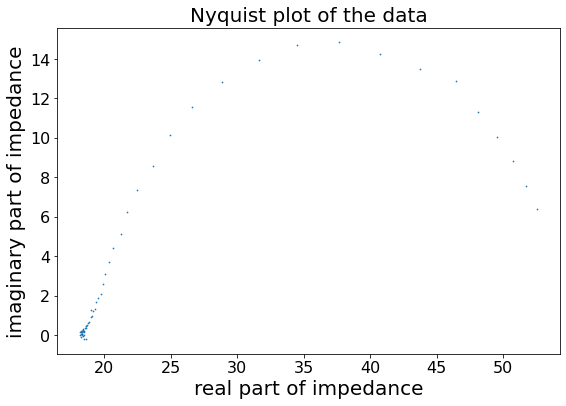

In [5]:
fig = plt.figure(figsize=(9, 6))
sub0 = fig.add_subplot(111)
plt.scatter(reals,imags,s=0.5) # note: np.cumsum also works
sub0.set_xlabel('real part of impedance', fontsize=20)
sub0.set_ylabel('imaginary part of impedance', fontsize=20)
sub0.set_title('Nyquist plot of the data', fontsize=20)
# sub0.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.tick_params(labelsize=16)
plt.show()

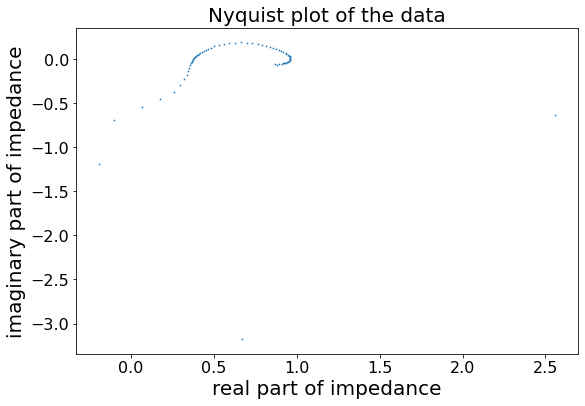

In [16]:
freq = data["freq/Hz"][62:132]
real = data["Re(Z)/Ohm"][62:132]
imag = data["=-@Im(Z)/@Ohm"][62:132]

fig = plt.figure(figsize=(9, 6))
sub0 = fig.add_subplot(111)
plt.scatter(real,imag,s=0.5) # note: np.cumsum also works
sub0.set_xlabel('real part of impedance', fontsize=20)
sub0.set_ylabel('imaginary part of impedance', fontsize=20)
sub0.set_title('Nyquist plot of the data', fontsize=20)
# sub0.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.tick_params(labelsize=16)
plt.show()

## Pre-processing + kk validation (Robert Black contributed to this part.) + extract ohmic resistance

In [12]:
# set plotting params and data directory

tick_size = 9
label_size = 11

plt.rcParams['font.family'] = 'serif'
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.rcParams['xtick.labelsize'] = tick_size
plt.rcParams['ytick.labelsize'] = tick_size
plt.rcParams['axes.labelsize'] = label_size
plt.rcParams['legend.fontsize'] = tick_size - 1

In [10]:
# define a function for EIS data pre-processing
def EIS_Clean(data = data,threshold = 0.05):
    # For Robert's Data

    abs_Ewe = df["GEIS"]["Ewe_bar"]
    abs_I = df["GEIS"]["I_bar"]
    Phase_Zwe = np.array(df["GEIS"]["phase_Zwe"])
    
    abs_Z = np.divide(abs_Ewe, abs_I)
    Re_Z = np.multiply(abs_Z, (np.cos(Phase_Zwe)))
    Im_Z = np.multiply(abs_Z , (np.sin(Phase_Zwe)))

    reals = Re_Z
    imags = Im_Z
    freq = np.array(df["GEIS"]["freq"])
    measurements = reals + imags*1j
    
    #Set plotting parameters for the non-filtered data
    fig,axes = plt.subplots(1,3,figsize=(15,3.5))

    axes[0].scatter(Re_Z,-Im_Z,s=1.5)
    axes[0].set_xlabel(r'$Re(Z) / \Omega$')
    axes[0].set_ylabel(r'$-Im(Z) / \Omega$')
    axes[0].set_title('Non-filtered')
    axes[1].scatter(freq,Re_Z,s=1.5)
    axes[1].set_xscale('log')
    axes[1].set_xlabel('freq (Hz)')
    axes[1].set_ylabel(r'$Re(Z) / \Omega$')
    axes[1].set_title('Non-filtered')
    axes[2].scatter(freq,-Im_Z,s=1.5)
    axes[2].set_xscale('log')
    axes[2].set_ylabel(r'$-Im(Z) / \Omega$')
    axes[2].set_xlabel('freq (Hz)')
    axes[2].set_title('Non-filtered')
    plt.show()

    ### FILTER 1 - High Frequency Region
    ### Find index where phase_Zwe == minimum, remove all high frequency values below zero
    index, = np.where(abs(Phase_Zwe[0:20]) == abs(Phase_Zwe[0:20]).min()) #finds minimum phase value, note returns as a tuple
    mask_phase = [True]*len(Phase_Zwe)
    for i in range(len(Phase_Zwe)):
        if i < index:
            mask_phase[i] = False

    freq = freq[index[0]:]
    Z = measurements[index[0]:]
    Re_Z = Re_Z[index[0]:]
    Im_Z = Im_Z[index[0]:]
    
    # find the ohmic resistance
    if index != 0:
        ohmic_resistance = Re_Z[0]
        
    ### FILTER 2 - Low Frequency Region
    ### Lin-KK data validation to remove 'noisy' data
    ### For Lin-KK, the residuals of Re(Z) and Im(Z) are what will be used as a filter. I have found based on the data set that
    ### somewhere ~0.05% works the best
    M, mu, Z_linKK, res_real, res_imag = linKK(freq, Z, c=.5, max_M=100, fit_type='complex', add_cap=True)

    # Plot residuals of Lin-KK for visualization purposes. 
    plt.plot(freq, res_imag, label = 'delta Im')
    plt.plot(freq, res_real, label = 'delta Re')
    plt.xlabel('freq (Hz)')
    plt.ylabel('Delta %')
    plt.xscale('log')
    plt.title('Link-KK Validation')
    plt.legend()
    
    # Need to set a threshold limit for when to filter out the noisy data of the residuals
    # threshold = 0.05 # USER DEFINE!!!

    mask = [False]*(len(res_imag))
    for i in range(len(res_imag)):
        if res_imag[i] < threshold:
            mask[i] = True
        else:
            break

    freq_mask = freq[mask]
    Z_mask = Z[mask]
    Re_Z_mask = Re_Z[mask]
    Im_Z_mask = Im_Z[mask]
    
    # find the ohmic resistance
    if index == 0:
        z = np.polyfit(Re_Z_mask,Im_Z_mask,5)
        fz = np.poly1d(z)
        x = symbols('x')
        ohmic_r_set = np.array(list(solveset(fz(x),x,domain=S.Reals)))
        ohmic_resistance = ohmic_r[np.where(ohmic_r < Re_Z_mask[0])].max()

    #Putting into a dataframe for use with plotting and program
    values = np.array([freq,Re_Z,Im_Z])
    values_mask = np.array([freq_mask,Re_Z_mask,Im_Z_mask])
    labels = ['freq','Zreal','Zimag']
    Zdf = pd.DataFrame(values.transpose(), columns = labels)
    Zdf_mask = pd.DataFrame(values_mask.transpose(), columns = labels)
    
    # Plot the data to see how the filter performed
    fig,axes = plt.subplots(1,3,figsize=(15,3.5))
    axes[0].scatter(Zdf_mask['Zreal'].values,-Zdf_mask['Zimag'].values,s=1.5)
    if index == 0:
        axes[0].scatter(Re_Z_mask, fz(Re_Z_mask),s=1.5,c='r')
    axes[0].set_xlabel(r'$Re(Z) / \Omega$')
    axes[0].set_ylabel(r'$-Im(Z) / \Omega$')
    axes[0].set_title('Filtered')
    axes[1].scatter(Zdf_mask['freq'].values,Zdf_mask['Zreal'].values,s=1.5)
    axes[1].set_xscale('log')
    axes[1].set_xlabel('freq (Hz)')
    axes[1].set_ylabel(r'$Re(Z) / \Omega$')
    axes[1].set_title('Filtered')
    axes[2].scatter(Zdf_mask['freq'].values,-Zdf_mask['Zimag'].values,s=1.5)
    axes[2].set_xscale('log')
    axes[2].set_ylabel(r'$-Im(Z) / \Omega$')
    axes[2].set_xlabel('freq (Hz)')
    axes[2].set_title('Filtered')
    plt.show()

    print(ohmic_resistance)
    return Zdf_mask,ohmic_resistance

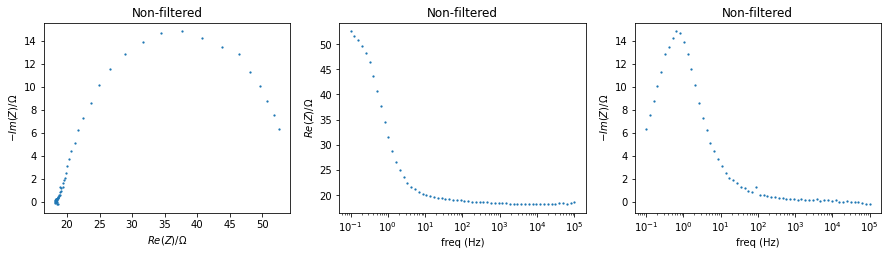

10 0.8194364515882049 0.31722416696171307
20 0.5254513229105516 0.14201264107163053


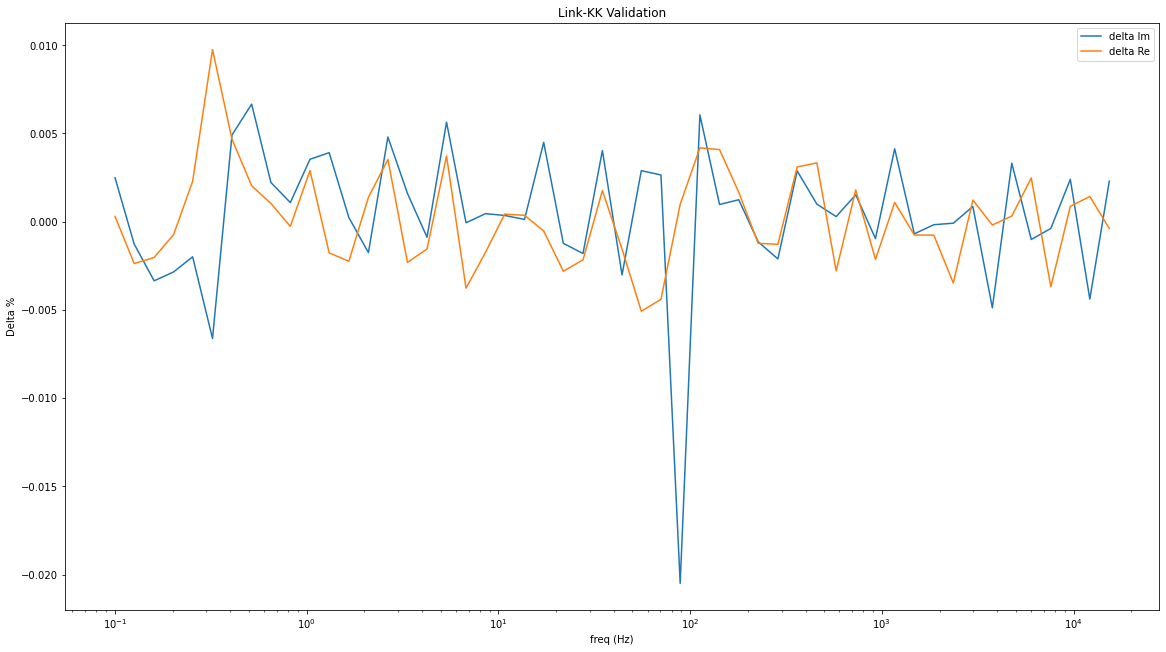

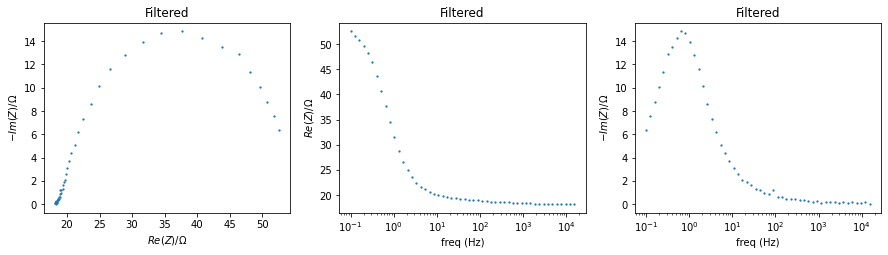

18.298434473095686


In [11]:
data_processed, ohmic_resistance = EIS_Clean(data=data,threshold=0.05)

## DRT +peak fitting 
(@This part is from Fang's code: https://github.com/fang-ren/Discover_MG_CoVZr

In [3]:
# Load the DRT results
DRT_file_path = "rbnb3p39_Test_1_Char_GEIS_13_raw_DRT.JSON"
f = open(DRT_file_path)
DRT_data = json.load(f)

In [4]:
DRT_data

{'DRT': {'tau': [1e-05,
   1.0843659686896109e-05,
   1.1758495540521557e-05,
   1.2750512407130129e-05,
   1.3826221737646564e-05,
   1.4992684327860471e-05,
   1.6257556664437934e-05,
   1.762914118095948e-05,
   1.9116440753857038e-05,
   2.0729217795953697e-05,
   2.2478058335487252e-05,
   2.4374441501222216e-05,
   2.643081486974103e-05,
   2.8660676169482503e-05,
   3.107866187782014e-05,
   3.370064329271925e-05,
   3.654383070957255e-05,
   3.962688638701478e-05,
   4.297004704320844e-05,
   4.6595256686646775e-05,
   5.0526310653356795e-05,
   5.478901179593945e-05,
   5.94113398496504e-05,
   6.44236350872137e-05,
   6.985879746785249e-05,
   7.57525025877192e-05,
   8.214343584919422e-05,
   8.90735463861044e-05,
   9.658832241158708e-05,
   0.00010473708979594497,
   0.00011357333583431052,
   0.00012315506032928262,
   0.00013354515629298989,
   0.0001448118227674533,
   0.00015702901247293774,
   0.00017027691722258995,
   0.00018464249428955425,
   0.0002002200371815584

In [7]:
tau = np.log(DRT_data['DRT']['tau'])
g_hmc = DRT_data['DRT']['g_hmc']

Text(0.5, 1.0, 'The DRT plot')

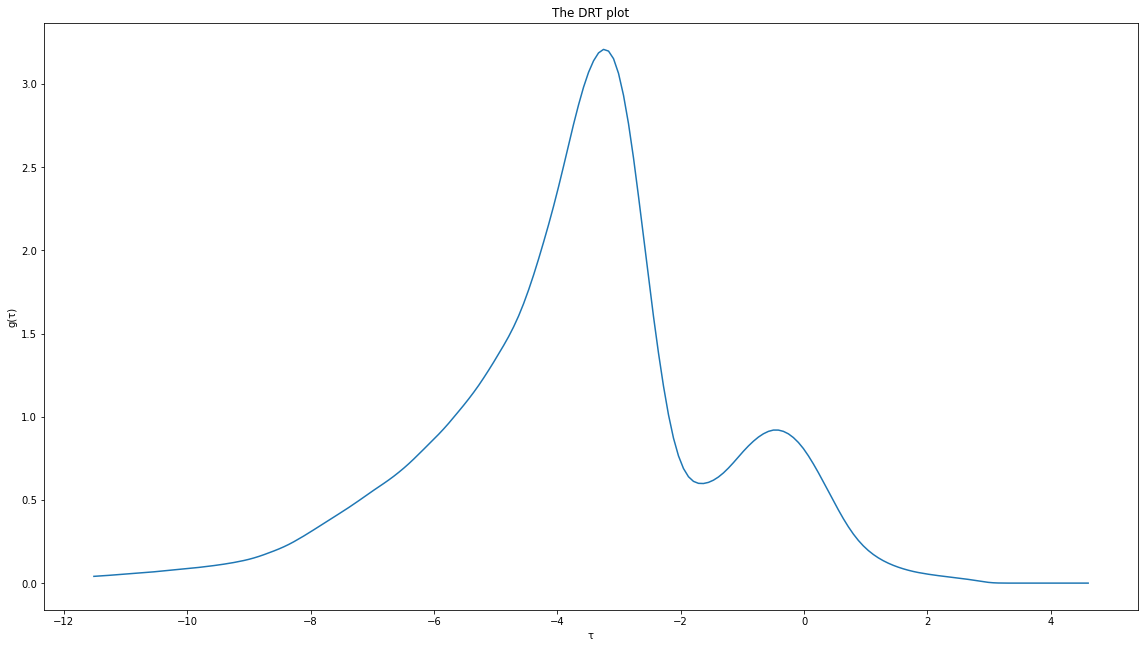

In [8]:
# plot the DRT figure

plt.plot(tau,g_hmc)
plt.xlabel('τ')
plt.ylabel('g(τ)')
plt.title("The DRT plot")

In [9]:
def func(x, *params):
    """
    create a Gaussian-Lorentzian fitted curve according to params
    """
    y = np.zeros_like(x)
    for i in range(0, len(params), 4):
        ctr = params[i]
        amp = params[i+1]
        wid = params[i+2]
        n = params[i+3]
        y = y + n * amp * np.exp(-4 * np.log(2) * ((x - ctr) / wid) ** 2) + (1 - n) * amp * wid ** 2 / 4 / (
        (x - ctr) ** 2 + wid ** 2 / 4)
    return y

In [10]:
def peakdet(v, delta, x = None):
    """
    Converted from MATLAB script at http://billauer.co.il/peakdet.html
    
    Returns two arrays
    
    function [maxtab, mintab]=peakdet(v, delta, x)
    %PEAKDET Detect peaks in a vector
    %        [MAXTAB, MINTAB] = PEAKDET(V, DELTA) finds the local
    %        maxima and minima ("peaks") in the vector V.
    %        MAXTAB and MINTAB consists of two columns. Column 1
    %        contains indices in V, and column 2 the found values.
    %      
    %        With [MAXTAB, MINTAB] = PEAKDET(V, DELTA, X) the indices
    %        in MAXTAB and MINTAB are replaced with the corresponding
    %        X-values.
    %
    %        A point is considered a maximum peak if it has the maximal
    %        value, and was preceded (to the left) by a value lower by
    %        DELTA.
    
    % Eli Billauer, 3.4.05 (Explicitly not copyrighted).
    % This function is released to the public domain; Any use is allowed.
    
    """
    maxtab = []
    mintab = []
       
    if x is None:
        x = range(len(v))
    
    v = np.asarray(v)
    
    if len(v) != len(x):
        sys.exit('Input vectors v and x must have same length')
    
    if not np.isscalar(delta):
        sys.exit('Input argument delta must be a scalar')
    
    if delta <= 0:
        sys.exit('Input argument delta must be positive')
    
    mn, mx = float('inf'), -float('inf')
    mnpos, mxpos = float('NaN'), float('NaN')
    
    lookformax = True
    
    for i in range(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]
        
        if lookformax:
            if this < mx-delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn+delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True
    return np.array(maxtab), np.array(mintab)

In [132]:
mins

array([[122.        ,   0.59859444]])

[102 136]


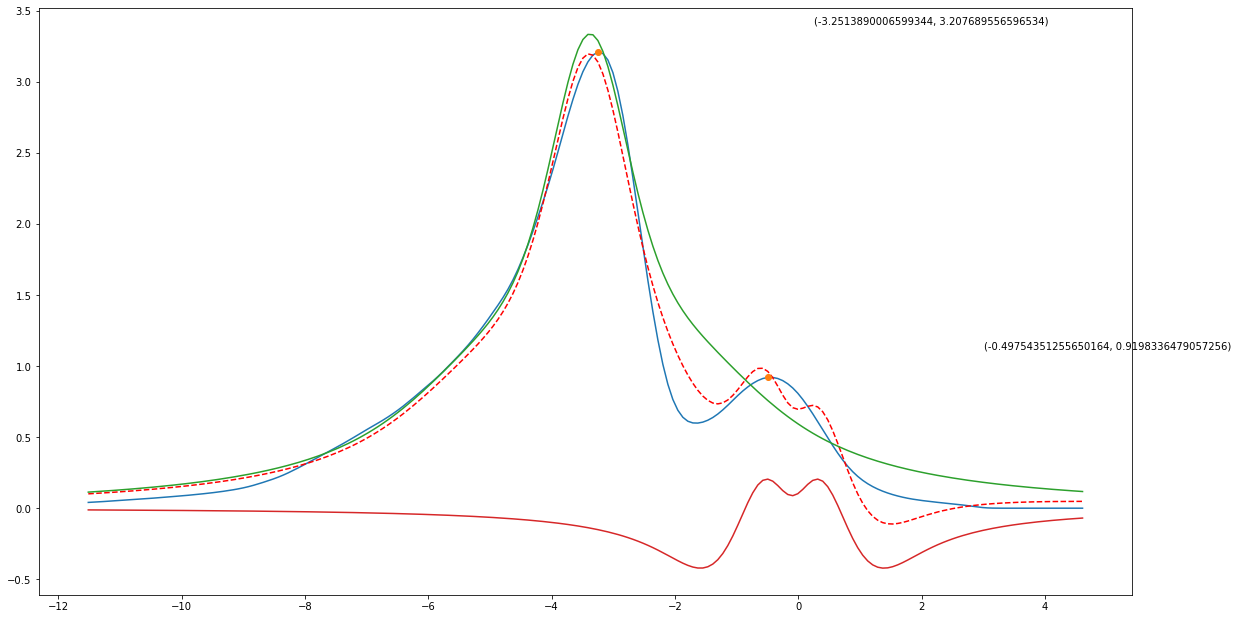

In [11]:
Qlist = tau
IntAve = g_hmc
#IntAve = smooth(IntAve, window_len=10)
maxs, mins = peakdet(IntAve, .01)
peaks = maxs[:,0].astype(int)
guess = []
low = []
high = []
print (peaks)
try:
    for peak in peaks:
        #how much can the peak center move from the initial guess
        guess.append(Qlist[peak])
        low.append(Qlist[peak]-1)
        high.append(Qlist[peak]+1)

        guess.append(IntAve[peak])
        low.append(0)
        high.append(IntAve[peak]+1)

        #this appears to be the width of the peak
        guess.append(2)
        low.append(0)
        high.append(1)
        
        guess.append(2)
        low.append(0)
        high.append(1)
    popt, pcov = curve_fit(func, Qlist, IntAve, p0=guess)
    #popt, pcov = curve_fit(func, Qlist, IntAve, p0=guess)
    fit = func(Qlist, *popt)
    plt.figure(1)
    plt.plot(Qlist, IntAve)
    plt.plot( Qlist, fit, 'r--')
    plt.plot(np.array(Qlist)[peaks], np.array(IntAve)[peaks], 'o')
    for i in range(len(np.array(Qlist)[peaks])):
        plt.text(np.array(Qlist)[peaks][i]+3.5, np.array(IntAve)[peaks][i]+0.2,s=f"{np.array(Qlist)[peaks][i], np.array(IntAve)[peaks][i]}")

    for i in range(0, len(popt), 4):
        ctr1 = popt[i]
        amp1 = popt[i+1]
        wid1 = popt[i+2]
        n1 = popt[i+3]
        curve1 = n1 * amp1 * np.exp( -4 * np.log(2) * ((Qlist - ctr1)/wid1)**2) + (1-n1) * amp1 * wid1**2 / 4 / ((Qlist-ctr1)**2 + wid1**2 / 4)
        plt.plot(Qlist, curve1)
except RuntimeError:
            print ("Failed to fit")

In [166]:
popt

array([-3.37811655,  3.33573629,  2.33212798, -0.6831833 , -0.10247566,
        0.08791057,  1.42663927, 36.13885868])

In [175]:
for i in range(0, len(popt), 4):
        ctr = popt[i]
        amp = popt[i+1]
        wid = popt[i+2]
        n = popt[i+3]
        print(n)

-3.7422916922844154
-3.9195160728225584


In [32]:
peak_numbers = len(np.array(Qlist)[peaks])

## Call Julia Program

In [27]:
from julia import Julia
jl = Julia(runtime=r"D:\Julia-1.7.2\bin\julia.exe")
n = jl.include('testtest.jl')

## Load the results

In [18]:
# load the circuits
file_path = "Test4_7_0.9.csv"
df_circuits = pd.read_csv(file_path)

In [19]:
df_circuits

,Circuit,Parameters
0,"[P1-R2,[P3,L4-R5]]","(P1w = 321.09004151255124, P1n = 0.89574790651..."
1,"[R1-L2,P3-R4-[R5,[C6,R7]]]","(R1 = 53.038823406509806, L2 = 2.2115157576107..."
2,"[P1,R2]-R3","(P1w = 116.66324180747166, P1n = 0.84285294911..."
3,"[P1,R2]-R3","(P1w = 116.66324181902428, P1n = 0.84285294925..."
4,"[R1-[C2,P3],P4]","(R1 = 29.29147409690113, C2 = 3.54882817899330..."
...,...,...
95,"[L1,R2]-R3-[R4,P5]","(L1 = 1.907930339239415e-7, R2 = 3.31051477277..."
96,"P1-[R2,C3]-R4","(P1w = 8.041438172933333, P1n = 0.327841482410..."
97,"[P1-R2,R3-C4-P5]","(P1w = 2.4963539464965234, P1n = 0.41429578937..."
98,"[R1,P2]-[R3,C4]-R5","(R1 = 17.627399586266066, P2w = 23.82615887617..."


In [14]:
# define some regular expression pattern to separate each kind of elements
resistor_p = re.compile(r'[R][0-9][a-z]? = [0-9]*\.[0-9]*')
capacitor_p = re.compile(r'[C][0-9][a-z]? = [0-9]*\.[0-9]*')
inductor_p = re.compile(r'[L][0-9][a-z]? = [0-9]*\.[0-9]*')
CPE_p = re.compile(r'[P][0-9][a-z]? = [0-9]*\.[0-9]*')

# 
numb_p = re.compile(r'[0-9]*\.[0-9]{4}')
# initialize some lists to store the values of each kind of elements
resistors_list = []
capacitors_list = []
inductors_list = []
CPEs_list = []

for i in range(len(df_circuits['Parameters'])):
    resistors = resistor_p.findall(df_circuits['Parameters'][i])
    capacitors = capacitor_p.findall(df_circuits['Parameters'][i])
    inductors = inductor_p.findall(df_circuits['Parameters'][i])
    CPEs = CPE_p.findall(df_circuits['Parameters'][i])
    
    resistors_list.append(resistors)
    capacitors_list.append(capacitors)
    inductors_list.append(inductors)
    CPEs_list.append(CPEs)
    
df_circuits['Resistors'] = resistors_list
df_circuits['Capacitors'] = capacitors_list
df_circuits['Inductors'] = inductors_list
df_circuits['CPEs'] = CPEs_list


In [15]:
df_circuits

,Circuit,Parameters,Resistors,Capacitors,Inductors,CPEs
0,"[P1-R2,[P3,L4-R5]]","(P1w = 321.09004151255124, P1n = 0.89574790651...","[R2 = 30.67069239794822, R5 = 427.5926082372904]",[],[L4 = 0.0016115677684073533],"[P1w = 321.09004151255124, P1n = 0.89574790651..."
1,"[R1-L2,P3-R4-[R5,[C6,R7]]]","(R1 = 53.038823406509806, L2 = 2.2115157576107...","[R1 = 53.038823406509806, R4 = 27.488147152910...",[C6 = 0.0035413501982459023],[L2 = 2.211515757610746],"[P3w = 40.90169733369939, P3n = 0.517278058967..."
2,"[P1,R2]-R3","(P1w = 116.66324180747166, P1n = 0.84285294911...","[R2 = 36.93934607317806, R3 = 18.30192000322114]",[],[],"[P1w = 116.66324180747166, P1n = 0.84285294911..."
3,"[P1,R2]-R3","(P1w = 116.66324181902428, P1n = 0.84285294925...","[R2 = 36.939346066345564, R3 = 18.301920001479...",[],[],"[P1w = 116.66324181902428, P1n = 0.84285294925..."
4,"[R1-[C2,P3],P4]","(R1 = 29.29147409690113, C2 = 3.54882817899330...",[R1 = 29.29147409690113],[C2 = 3.548828178993303],[],"[P3w = 295.4727592713146, P3n = 0.875279918673..."
...,...,...,...,...,...,...
95,"[L1,R2]-R3-[R4,P5]","(L1 = 1.907930339239415e-7, R2 = 3.31051477277...","[R2 = 3.310514772777255, R3 = 18.3015208023388...",[],[L1 = 1.907930339239415],"[P5w = 116.65555291334444, P5n = 0.84280718053..."
96,"P1-[R2,C3]-R4","(P1w = 8.041438172933333, P1n = 0.327841482410...","[R2 = 25.389122709325093, R4 = 17.88050128030263]",[C3 = 0.008202065058669139],[],"[P1w = 8.041438172933333, P1n = 0.327841482410..."
97,"[P1-R2,R3-C4-P5]","(P1w = 2.4963539464965234, P1n = 0.41429578937...","[R2 = 50.38609542027334, R3 = 28.147789153558445]",[C4 = 0.0030456451505838627],[],"[P1w = 2.4963539464965234, P1n = 0.41429578937..."
98,"[R1,P2]-[R3,C4]-R5","(R1 = 17.627399586266066, P2w = 23.82615887617...","[R1 = 17.627399586266066, R3 = 22.282995069686...",[C4 = 0.009999999999999981],[],"[P2w = 23.826158876172883, P2n = 0.54888310785..."


###  Filtering results with resistance (range)

In [37]:
# deleting_list = []
# for i in range(len(df_circuits['Resistors'])):
#     resistor_values_list = []
#     for j in range(len(df_circuits['Resistors'][i])):
#         resistor_values_list.append(float(numb_p.findall(df_circuits['Resistors'][i][j])[0]))
#     resistor_values_array = np.array([resistor_values_list])
#     resistor_values_array_T = resistor_values_array.T
#     if (resistor_values_array/resistor_values_array_T >= 10).any() or (resistor_values_array/resistor_values_array_T <= 0.1).any():
#         df_circuits.drop([i],inplace = True)
        
# df_circuits.reset_index(drop=True,inplace=True)
        
    

In [168]:
# df_circuits

,Circuit,Parameters,Resistors,Capacitors,Inductors,CPEs
0,"[P1,R2]-R3","(P1w = 116.66324180747166, P1n = 0.84285294911...","[R2 = 36.93934607317806, R3 = 18.30192000322114]",[],[],"[P1w = 116.66324180747166, P1n = 0.84285294911..."
1,"[P1,R2]-R3","(P1w = 116.66324181902428, P1n = 0.84285294925...","[R2 = 36.939346066345564, R3 = 18.301920001479...",[],[],"[P1w = 116.66324181902428, P1n = 0.84285294925..."
2,"[R1-[C2,P3],P4]","(R1 = 29.29147409690113, C2 = 3.54882817899330...",[R1 = 29.29147409690113],[C2 = 3.548828178993303],[],"[P3w = 295.4727592713146, P3n = 0.875279918673..."
3,"P1-[R2,C3]-C4","(P1w = 20.255829782847957, P1n = 0.00925545620...",[R2 = 15.293129032988995],"[C3 = 0.005357724945165028, C4 = 0.01]",[],"[P1w = 20.255829782847957, P1n = 0.00925545620..."
4,"[R1,P2]-P3-R4-[C5,L6]","(R1 = 30.673174378138622, P2w = 116.9486781724...","[R1 = 30.673174378138622, R4 = 17.928235208434...",[C5 = 0.009999999999999603],[L6 = 1.270261173762957],"[P2w = 116.94867817246204, P2n = 0.91917770845..."
...,...,...,...,...,...,...
82,"[R1-[R2,C3],P4-R5]","(R1 = 26.044938631888535, R2 = 30.026130719051...","[R1 = 26.044938631888535, R2 = 30.026130719051...",[C3 = 0.006001382491301986],[],"[P4w = 407.92821162910616, P4n = 0.61197924920..."
83,"P1-[R2,C3]-R4","(P1w = 8.041438172933333, P1n = 0.327841482410...","[R2 = 25.389122709325093, R4 = 17.88050128030263]",[C3 = 0.008202065058669139],[],"[P1w = 8.041438172933333, P1n = 0.327841482410..."
84,"[P1-R2,R3-C4-P5]","(P1w = 2.4963539464965234, P1n = 0.41429578937...","[R2 = 50.38609542027334, R3 = 28.147789153558445]",[C4 = 0.0030456451505838627],[],"[P1w = 2.4963539464965234, P1n = 0.41429578937..."
85,"[R1,P2]-[R3,C4]-R5","(R1 = 17.627399586266066, P2w = 23.82615887617...","[R1 = 17.627399586266066, R3 = 22.282995069686...",[C4 = 0.009999999999999981],[],"[P2w = 23.826158876172883, P2n = 0.54888310785..."


### Filtering results with capacitance

In [16]:
# delete the circuits with Capacitor
for i in range(len(df_circuits['Capacitors'])):
    if df_circuits['Capacitors'][i] != []:
        df_circuits.drop([i],inplace = True)

df_circuits.reset_index(drop=True,inplace=True)


In [17]:
df_circuits

,Circuit,Parameters,Resistors,Capacitors,Inductors,CPEs
0,"[P1-R2,[P3,L4-R5]]","(P1w = 321.09004151255124, P1n = 0.89574790651...","[R2 = 30.67069239794822, R5 = 427.5926082372904]",[],[L4 = 0.0016115677684073533],"[P1w = 321.09004151255124, P1n = 0.89574790651..."
1,"[P1,R2]-R3","(P1w = 116.66324180747166, P1n = 0.84285294911...","[R2 = 36.93934607317806, R3 = 18.30192000322114]",[],[],"[P1w = 116.66324180747166, P1n = 0.84285294911..."
2,"[P1,R2]-R3","(P1w = 116.66324181902428, P1n = 0.84285294925...","[R2 = 36.939346066345564, R3 = 18.301920001479...",[],[],"[P1w = 116.66324181902428, P1n = 0.84285294925..."
3,"[R1-L2,P3-R4]","(R1 = 55.25826114584234, L2 = 1.55218173007144...","[R1 = 55.25826114584234, R4 = 18.20599681139756]",[],[L2 = 1.5521817300714484],"[P3w = 234.00995438684996, P3n = 0.84500072432..."
4,"P1-[R2,P3]-R4","(P1w = 4.33711736911608, P1n = 0.2749958730991...","[R2 = 30.66719342634599, R4 = 17.926127593712536]",[],[],"[P1w = 4.33711736911608, P1n = 0.2749958730991..."
5,"[R1-[L2,P3],P4-R5]","(R1 = 55.247578469841486, L2 = 7.7575410811456...","[R1 = 55.247578469841486, R5 = 27.360986243324...",[],[L2 = 7.757541081145631],"[P3w = 174419.91044260038, P3n = 0.94257991172..."
6,"[R1,P2]-R3","(R1 = 36.93934606753384, P2w = 116.66324172260...","[R1 = 36.93934606753384, R3 = 18.301920005161126]",[],[],"[P2w = 116.66324172260413, P2n = 0.84285294928..."
7,"[R1,[R2,[P3-[R4,R5],R6]]]","(R1 = 7.389998891743529e8, R2 = 55.24127340545...","[R1 = 7.389998891743529, R2 = 55.2412734054554...",[],[],"[P3w = 260.905288147883, P3n = 0.8428529496220..."
8,"[R1,[R2,P3]-P4]-R5","(R1 = 35.954502150427324, R2 = 1.0499147936127...","[R1 = 35.954502150427324, R2 = 1.0499147936127...",[],[],"[P3w = 59.95169789125724, P3n = 0.675230216696..."
9,"[R1,P2-R3]","(R1 = 55.24126609941385, P2w = 260.90528713839...","[R1 = 55.24126609941385, R3 = 27.36976530375484]",[],[],"[P2w = 260.9052871383904, P2n = 0.842852948498..."


### Filtering results with ohmic resistance

In [44]:
def find_series_elements(circuit):
    series_circuit = []
    identifior = 0
    for i in range(len(circuit)):
        if circuit[i] == '[':
            identifior += 1
        if identifior == 0:
            series_circuit.append(circuit[i])
        if circuit[i] == ']':
            identifior -= 1
        # elif identifior != 0:
        #    index_list.append([False])
    series_circuit = ''.join(series_circuit)
    return series_circuit

In [45]:
series_circuit = find_series_elements(circuit = df_circuits['Circuit'][12])
series_circuit

'R1-'

In [46]:
find_R = re.compile(r'R[0-9]')
series_resistors = find_R.findall(series_circuit)
series_resistors

['R1']

In [47]:
df_circuits['Circuit'][12]

'R1-[P2,R3]'

In [48]:
# delete the circuit without ohmic resistance or wrong ohmic resistance
series_list = []
for i in range(len(df_circuits['Circuit'])):
    circuits = df_circuits['Circuit'][i]
    # find the series elements
    series_circuit = find_series_elements(circuit = circuits)
    # store the series elements of each circuit in a list for future uses
    series_list.append(series_circuit)
    # define a pattern to find R in series elements
    find_R = re.compile(r'R[0-9]')
    series_resistors = find_R.findall(series_circuit)
    # initiate a list to store series resistors' values for future comparison
    R_values_list = []
    for j in range(len(series_resistors)):
        value_R_p = re.compile(f'{series_resistors[j]} = [0-9]*\.[0-9]*')
        values_R_withid = value_R_p.findall(''.join(df_circuits['Resistors'][i]))
        value_R_p2 = re.compile(r'[0-9]*\.[0-9]*')
        for k in range(len(values_R_withid)):
            R_value = value_R_p2.findall(values_R_withid[k])
            R_values_list.append(R_value)
    if R_values_list == []:
        df_circuits.drop([i],inplace = True)
    else:
        value_identify_list = []
        for m in range(len(R_values_list)):
            if float(R_values_list[m][0]) < ohmic_resistance * 0.85 or float(R_values_list[m][0]) > ohmic_resistance * 1.15:
                value_identify_list.append(False)
            else:
                value_identify_list.append(True)
        if True not in value_identify_list:
            df_circuits.drop([i],inplace = True)

df_circuits.reset_index(drop=True,inplace=True)


In [49]:
df_circuits

,Circuit,Parameters,Resistors,Capacitors,Inductors,CPEs
0,"[P1,R2]-R3","(P1w = 116.66324180747166, P1n = 0.84285294911...","[R2 = 36.93934607317806, R3 = 18.30192000322114]",[],[],"[P1w = 116.66324180747166, P1n = 0.84285294911..."
1,"[P1,R2]-R3","(P1w = 116.66324181902428, P1n = 0.84285294925...","[R2 = 36.939346066345564, R3 = 18.301920001479...",[],[],"[P1w = 116.66324181902428, P1n = 0.84285294925..."
2,"P1-[R2,P3]-R4","(P1w = 4.33711736911608, P1n = 0.2749958730991...","[R2 = 30.66719342634599, R4 = 17.926127593712536]",[],[],"[P1w = 4.33711736911608, P1n = 0.2749958730991..."
3,"[R1,P2]-R3","(R1 = 36.93934606753384, P2w = 116.66324172260...","[R1 = 36.93934606753384, R3 = 18.301920005161126]",[],[],"[P2w = 116.66324172260413, P2n = 0.84285294928..."
4,"[R1,[R2,P3]-P4]-R5","(R1 = 35.954502150427324, R2 = 1.0499147936127...","[R1 = 35.954502150427324, R2 = 1.0499147936127...",[],[],"[P3w = 59.95169789125724, P3n = 0.675230216696..."
5,"[R1,P2]-R3","(R1 = 36.93934604829248, P2w = 116.66324168931...","[R1 = 36.93934604829248, R3 = 18.301920007027295]",[],[],"[P2w = 116.66324168931236, P2n = 0.84285294890..."
6,"R1-[P2,R3]","(R1 = 18.301920003005616, P2w = 116.6632415754...","[R1 = 18.301920003005616, R3 = 36.93934607374494]",[],[],"[P2w = 116.66324157542962, P2n = 0.84285294877..."
7,"R1-[P2,R3]","(R1 = 18.301920002520635, P2w = 116.6632416751...","[R1 = 18.301920002520635, R3 = 36.93934604648206]",[],[],"[P2w = 116.66324167517276, P2n = 0.84285294953..."
8,"P1-[P2,R3]-R4","(P1w = 4.337117448908525, P1n = 0.274995873860...","[R3 = 30.66719331126788, R4 = 17.926127593359436]",[],[],"[P1w = 4.337117448908525, P1n = 0.274995873860..."
9,"[L1,R2]-R3-[R4,P5]","(L1 = 1.907930339239415e-7, R2 = 3.31051477277...","[R2 = 3.310514772777255, R3 = 18.3015208023388...",[],[L1 = 1.907930339239415],"[P5w = 116.65555291334444, P5n = 0.84280718053..."


### Filtering the data with inductors

In [28]:
# delete the circuits with Capacitor
for i in range(len(df_circuits['Inductors'])):
    if df_circuits['Inductors'][i] != []:
        df_circuits.drop([i],inplace = True)

df_circuits.reset_index(drop=True,inplace=True)


In [29]:
df_circuits

,Circuit,Parameters,Resistors,Capacitors,Inductors,CPEs
0,"[P1,R2]-R3","(P1w = 116.66324180747166, P1n = 0.84285294911...","[R2 = 36.93934607317806, R3 = 18.30192000322114]",[],[],"[P1w = 116.66324180747166, P1n = 0.84285294911..."
1,"[P1,R2]-R3","(P1w = 116.66324181902428, P1n = 0.84285294925...","[R2 = 36.939346066345564, R3 = 18.301920001479...",[],[],"[P1w = 116.66324181902428, P1n = 0.84285294925..."
2,"P1-[R2,P3]-R4","(P1w = 4.33711736911608, P1n = 0.2749958730991...","[R2 = 30.66719342634599, R4 = 17.926127593712536]",[],[],"[P1w = 4.33711736911608, P1n = 0.2749958730991..."
3,"[R1,P2]-R3","(R1 = 36.93934606753384, P2w = 116.66324172260...","[R1 = 36.93934606753384, R3 = 18.301920005161126]",[],[],"[P2w = 116.66324172260413, P2n = 0.84285294928..."
4,"[R1,[R2,[P3-[R4,R5],R6]]]","(R1 = 7.389998891743529e8, R2 = 55.24127340545...","[R1 = 7.389998891743529, R2 = 55.2412734054554...",[],[],"[P3w = 260.905288147883, P3n = 0.8428529496220..."
5,"[R1,[R2,P3]-P4]-R5","(R1 = 35.954502150427324, R2 = 1.0499147936127...","[R1 = 35.954502150427324, R2 = 1.0499147936127...",[],[],"[P3w = 59.95169789125724, P3n = 0.675230216696..."
6,"[R1,P2-R3]","(R1 = 55.24126609941385, P2w = 260.90528713839...","[R1 = 55.24126609941385, R3 = 27.36976530375484]",[],[],"[P2w = 260.9052871383904, P2n = 0.842852948498..."
7,"[R1,P2]-R3","(R1 = 36.93934604829248, P2w = 116.66324168931...","[R1 = 36.93934604829248, R3 = 18.301920007027295]",[],[],"[P2w = 116.66324168931236, P2n = 0.84285294890..."
8,"R1-[P2,R3]","(R1 = 18.301920003005616, P2w = 116.6632415754...","[R1 = 18.301920003005616, R3 = 36.93934607374494]",[],[],"[P2w = 116.66324157542962, P2n = 0.84285294877..."
9,"[[P1,R2]-R3,[P4,R5]]","(P1w = 295.472742045751, P1n = 0.8752799186377...","[R2 = 9.999984077565509, R3 = 29.2914732659942...",[],[],"[P1w = 295.472742045751, P1n = 0.8752799186377..."


## Generating mathematical expression

In [30]:
def generate_mathematical_expression(input = df_circuits):
    
    # define two kinds of pattern to find all elements in the circuit
    test_pattern = re.compile(r'([CLRP])([0-9])+')
    test_pattern_2 = re.compile(r'[CLRP][0-9]')
    
    # create a list to store the mathematical expressions
    new_circuits = []
    
    for i in range(len(input['Circuit'])):
        circuit = input['Circuit'][i]
        for j,k in zip(["-","[",",","]"],["+","((",")**(-1)+(",")**(-1))**(-1)"]):
            circuit = circuit.replace(j,k)
        test_results = test_pattern.findall(circuit)
        test_results_2 = test_pattern_2.findall(circuit)
        
        for m in range(len(test_results)):
            if test_results[m][0] == 'R':
                circuit = circuit.replace(test_results_2[m],"X")
            elif test_results[m][0] == 'C':
                circuit = circuit.replace(test_results_2[m],"(1/(2*1j*np.pi*F*X))")
            elif test_results[m][0] == 'L':
                circuit = circuit.replace(test_results_2[m],"(2*1j*np.pi*F*X)")
            elif test_results[m][0] == 'P':
                circuit = circuit.replace(test_results_2[m],"X*(2*np.pi*F)**(-Y)*(np.cos((np.pi*Y)*0.5)-np.sin((np.pi*X)*0.5)*1j)")
        
        new_temp_circuit = []
        counter = 0
        
        for n in range(len(circuit)):
            if circuit[n] == 'X':
                new_temp_circuit.append(f"X[{str(counter)}]")
                counter += 1
            elif circuit[n] == 'Y':
                new_temp_circuit.append(f"X[{str(counter)}]")
            else:
                new_temp_circuit.append(circuit[n])
        new_circuit = ''.join(new_temp_circuit)
        new_circuits.append(new_circuit)
        

    input['Mathematical expressions'] = new_circuits
    
    return input
 

In [31]:
df_circuits = generate_mathematical_expression(input = df_circuits)
df_circuits

,Circuit,Parameters,Resistors,Capacitors,Inductors,CPEs,Mathematical expressions
0,"[P1,R2]-R3","(P1w = 116.66324180747166, P1n = 0.84285294911...","[R2 = 36.93934607317806, R3 = 18.30192000322114]",[],[],"[P1w = 116.66324180747166, P1n = 0.84285294911...",((X[0]*(2*np.pi*F)**(-X[1])*(np.cos((np.pi*X[1...
1,"[P1,R2]-R3","(P1w = 116.66324181902428, P1n = 0.84285294925...","[R2 = 36.939346066345564, R3 = 18.301920001479...",[],[],"[P1w = 116.66324181902428, P1n = 0.84285294925...",((X[0]*(2*np.pi*F)**(-X[1])*(np.cos((np.pi*X[1...
2,"P1-[R2,P3]-R4","(P1w = 4.33711736911608, P1n = 0.2749958730991...","[R2 = 30.66719342634599, R4 = 17.926127593712536]",[],[],"[P1w = 4.33711736911608, P1n = 0.2749958730991...",X[0]*(2*np.pi*F)**(-X[1])*(np.cos((np.pi*X[1])...
3,"[R1,P2]-R3","(R1 = 36.93934606753384, P2w = 116.66324172260...","[R1 = 36.93934606753384, R3 = 18.301920005161126]",[],[],"[P2w = 116.66324172260413, P2n = 0.84285294928...",((X[0])**(-1)+(X[1]*(2*np.pi*F)**(-X[2])*(np.c...
4,"[R1,[R2,[P3-[R4,R5],R6]]]","(R1 = 7.389998891743529e8, R2 = 55.24127340545...","[R1 = 7.389998891743529, R2 = 55.2412734054554...",[],[],"[P3w = 260.905288147883, P3n = 0.8428529496220...",((X[0])**(-1)+(((X[1])**(-1)+(((X[2]*(2*np.pi*...
5,"[R1,[R2,P3]-P4]-R5","(R1 = 35.954502150427324, R2 = 1.0499147936127...","[R1 = 35.954502150427324, R2 = 1.0499147936127...",[],[],"[P3w = 59.95169789125724, P3n = 0.675230216696...",((X[0])**(-1)+(((X[1])**(-1)+(X[2]*(2*np.pi*F)...
6,"[R1,P2-R3]","(R1 = 55.24126609941385, P2w = 260.90528713839...","[R1 = 55.24126609941385, R3 = 27.36976530375484]",[],[],"[P2w = 260.9052871383904, P2n = 0.842852948498...",((X[0])**(-1)+(X[1]*(2*np.pi*F)**(-X[2])*(np.c...
7,"[R1,P2]-R3","(R1 = 36.93934604829248, P2w = 116.66324168931...","[R1 = 36.93934604829248, R3 = 18.301920007027295]",[],[],"[P2w = 116.66324168931236, P2n = 0.84285294890...",((X[0])**(-1)+(X[1]*(2*np.pi*F)**(-X[2])*(np.c...
8,"R1-[P2,R3]","(R1 = 18.301920003005616, P2w = 116.6632415754...","[R1 = 18.301920003005616, R3 = 36.93934607374494]",[],[],"[P2w = 116.66324157542962, P2n = 0.84285294877...",X[0]+((X[1]*(2*np.pi*F)**(-X[2])*(np.cos((np.p...
9,"[[P1,R2]-R3,[P4,R5]]","(P1w = 295.472742045751, P1n = 0.8752799186377...","[R2 = 9.999984077565509, R3 = 29.2914732659942...",[],[],"[P1w = 295.472742045751, P1n = 0.8752799186377...",((((X[0]*(2*np.pi*F)**(-X[1])*(np.cos((np.pi*X...


## Find the identical circuits and combine them

In [25]:
# convert the circuit string to nparray
def s_to_a_convert(input_circuit):
    circuit = re.sub(r'[0-9]+', '', input_circuit)
    pat = re.compile(r'[RCLP\[\]\-,]')
    str = pat.findall(circuit)
    circuit_array = np.zeros((1,len(str)))
    for i in range(len(str)):
        # encoding rules: R=1，C=2，L=3，P=4，[=5,]=6,"-"=7,","=8
        if str[i] == "R":
            circuit_array[0,i] = 1
        elif str[i] == "C":
            circuit_array[0,i] = 2
        elif str[i] == "L":
            circuit_array[0,i] = 3
        elif str[i] == "P":
            circuit_array[0,i] = 4
        elif str[i] == "[":
            circuit_array[0,i] = 5
        elif str[i] == "]":
            circuit_array[0,i] = 6
        elif str[i] == "-":
            circuit_array[0,i] = 7
        elif str[i] == ",":
            circuit_array[0,i] = 8
    return circuit_array

In [26]:
# define a function to count components numbers
def count_components(circuit,symbols = True):
    
    # define the pattern for each components (p denotes pattern)
    r_p = re.compile(r'[R]')
    c_p = re.compile(r'[C]')
    l_p = re.compile(r'[L]')
    p_p = re.compile(r'[P]')
    if symbols:
        b_p = re.compile(r'[\[\]]')
        d_p = re.compile(r'[\-]')
        comma_p = re.compile(r'[,]')
    
    # find the individual components (n denotes number)
    r_n = r_p.findall(circuit) 
    c_n = c_p.findall(circuit)
    l_n = l_p.findall(circuit)
    p_n = p_p.findall(circuit)
    if symbols:
        b_n = b_p.findall(circuit)
        d_n = d_p.findall(circuit)
        comma_n = comma_p.findall(circuit)
    
    # create array to store the numbers of components
    if symbols:
        array_components_numbers = np.zeros((1,7))
    else:
        array_components_numbers = np.zeros((1,4))
        
    # store the numbers of components into array
    array_components_numbers[0,0] = len(r_n)
    array_components_numbers[0,1] = len(c_n)
    array_components_numbers[0,2] = len(l_n)
    array_components_numbers[0,3] = len(p_n)
    if symbols:
        array_components_numbers[0,4] = len(b_n) # ÷2代表有几个并联结构
        array_components_numbers[0,5] = len(d_n)
        array_components_numbers[0,6] = len(comma_n) # +并联结构数代表并联支路总数
        
    return array_components_numbers

In [ ]:
#locator

In [20]:
def rank_the_structure(circuit_array):
    ranks_array = np.zeros([1,len(circuit_array)])
    ranker = 0
    for i in range(len(circuit_array)):
        if circuit_array[i] == 5:
            ranker += 1
            # -1: [
            ranks_array[0,i]= -1 
        # elif circuit_array[i] == 8:
        #    ranker += 0.5
        #    ranks_store[0,i] = -3
            # -3: ,
        elif circuit_array[i] == 6:
            ranker -= 1
            ranks_array[0,i] = -2
        else:
            ranks_array[0,i] = ranker
    return ranks_array

In [21]:
def structure_deconstructor(ranks_array):
    # initialize an array to store 0_level series structure
    # lvl_0 = np.zeros
    # initialize a list to store the indexs 
    indexs_list = []
    # initialize a list to store the index lists
    indexs_lists = []
    for i in range(len(ranks_array[0])):
        if ranks_array[0][i] < 0:
            indexs_lists.append(indexs_list)
            indexs_list = []
        elif ranks_array[0][i] >= 1:
            indexs_list.append(i)
    indexs_lists = [x for x in indexs_lists if x != []]
    return indexs_lists

In [182]:
def structure_extractor(circuit_array,ranks_array, indexs_lists):
    characteristic_array = np.zeros([len(indexs_lists),max(len(index) for index in indexs_lists)+1])
    for i in range(len(indexs_lists)):
        if ranks_array[0][indexs_lists[i][0]] == 1:
            characteristic_array[i][0] = 1
        elif ranks_array[0][indexs_lists[i][0]] == 2:
            characteristic_array[i][0] = 2
        elif ranks_array[0][indexs_lists[i][0]] == 3:
            characteristic_array[i][0] = 3
        elif ranks_array[0][indexs_lists[i][0]] == 4:
            characteristic_array[i][0] = 4
        elif ranks_array[0][indexs_lists[i][0]] == 5:
            characteristic_array[i][0] = 5
        else:
            assert ("Error:Circuit's too complex")

        segment = np.array(sorted(circuit_array[0][indexs[i]]))
        characteristic_array[i][1:1+len(segment)] = segment.reshape(1,len(segment))

    sort_list = [characteristic_array[:,i] for i in range(characteristic_array.shape[1])]
    idex = np.lexsort(sort_list)
    
    characteristic_array = characteristic_array[idex,:]
    
    return characteristic_array

In [ ]:
def find_parallel(circuit_array[0]):
    for i in range(len(circuit_array)):
        ranks_array = np.zeros([1,len(circuit_array)])
        ranker = 0
        for i in range(len(circuit_array)):
            if circuit_array[i] == 5:
                ranker += 1
                # -1: [
                ranks_array[0,i]= -1 
            # elif circuit_array[i] == 8:
            #    ranker += 0.5
            #    ranks_store[0,i] = -3
                # -3: ,
            elif circuit_array[i] == 6:
                ranker -= 1
                ranks_array[0,i] = -2
            else:
                ranks_array[0,i] = ranker

In [188]:
test_case = rank_the_structure(circuit_array[0])
test_case

array([[-1.,  1.,  1.,  1., -2.,  0., -1.,  1.,  1.,  1.,  1.,  1., -2.,
         0., -1.,  1.,  1., -1.,  2.,  2.,  2.,  2.,  2., -2.,  1.,  1.,
        -2.,  0.,  0.,  0.,  0.]])

In [187]:
for i in range(len(test_case[0])):
    identifior = 0

SyntaxError: invalid syntax (<ipython-input-187-1d2e3655c147>, line 1)

In [183]:
structure_extractor(circuit_array,rank_the_structure(circuit_array[0]),structure_deconstructor(rank_the_structure(circuit_array[0])))

array([[1., 2., 7., 0., 0., 0.],
       [1., 1., 8., 0., 0., 0.],
       [1., 1., 2., 8., 0., 0.],
       [1., 1., 1., 2., 7., 8.],
       [2., 1., 1., 2., 7., 8.]])

# 有BUG！！！

In [140]:
# detect the number of parallel structures and their levels(one group of [] denote one parallel structure)
# find all [ and ]
def parallel_structure_identifior(input_circuit,circuit_array):
    b_p = re.compile(r'[\[\]]')
    b_n = b_p.findall(input_circuit)
    parallel_number = len(b_n)/2
    
    pat_all_components = re.compile(r'[RCLP\[\]\-,]')
    circuit_str = pat_all_components.findall(input_circuit)
    
    #  identify the levels of each parallel structure
    if parallel_number == 0:
        separate_parallel_counter = 0
    else:
        # initialize the counter of parallel structurs and their levels
        separate_parallel_counter = 1
        lvl_counter = 1
        # initialize a list to store the levels of each parallel structure
        lvl_counter_list = []
        for i in range(1,len(b_n)):
            if b_n[i-1] == b_n[i] == "]":
                lvl_counter += 1
            if b_n[i-1] == "]" and b_n[i] == "[":
                separate_parallel_counter += 1
                lvl_counter_list.append(lvl_counter)
                lvl_counter = 1
        lvl_counter_list.append(lvl_counter)

    # the sum of lvl_counter_list should equal to parallel_number 
    if sum(lvl_counter_list) == parallel_number:
        print('True')
    else:
        print('Fail')
    # separate and count the components numbers each parallel structure
    l_s_position = np.where(circuit_array==5)[1]
    r_s_position = np.where(circuit_array==6)[1]  
    
    segments = []
    counter = 0
    for seg in range(separate_parallel_counter):
        lvl = lvl_counter_list[seg]
        segment = circuit_str[l_s_position[counter]:r_s_position[counter+lvl-1]+1]
        segments.append(segment)
        if lvl > 1:
            for i in range(lvl-1):
                sub_segment = circuit_str[l_s_position[counter+i+1]:r_s_position[counter+lvl-1-i-1]+1]
                segments.append(sub_segment)
        counter = counter + lvl 

    # combine these elements of segments as a string
    segments_str =[]
    for i in range(len(segments)):
        segment_str = ''.join(segments[i])
        segments_str.append(segment_str)
    #print(segments_str)
    
    # initialize an array to store the components numbers of each segment
    segments_components_array = np.zeros([int(parallel_number),7])
    for i in range(len(segments)):
        component_numbers = count_components(circuit=segments_str[i],symbols = True)
        segments_components_array[i,:] = component_numbers
    
    # sort the segments for further comparison
    print(segments_components_array)

    idex = np.lexsort([segments_components_array[:,0],
                       segments_components_array[:,1],
                       segments_components_array[:,2],
                       segments_components_array[:,3],                      
                       segments_components_array[:,4],                      
                       segments_components_array[:,5],
                       segments_components_array[:,6]])
    segments_components_array = segments_components_array[idex,:]
    print(segments_components_array)
    
    # count the numbers of each component in the most inner parallel structure
    comma_position = np.where(circuit_array==8)[1]
    # initiate an array to store the characteristics of these inner parallel structures
    most_inner = np.zeros([len(lvl_counter_list),7])
    most_inner_strs = []
    counter = 0 - 1
    for i in range(len(lvl_counter_list)):
        counter += lvl_counter_list[i]

        most_inner_str_l = ''.join(circuit_str[l_s_position[counter]+1:comma_position[counter+1-lvl_counter_list[i]]])
        most_inner_str_r = ''.join(circuit_str[comma_position[counter+1-lvl_counter_list[i]]+1:r_s_position[counter+1-lvl_counter_list[i]]])
        
        print([most_inner_str_l,most_inner_str_r])
        print(lvl_counter_list)
    return segments_components_array,lvl_counter_list

In [50]:
input_circuit = '[R-C,R]-[R,[R,C-R]-C]-R-P-[R,C]'
input_circuit[2]

'-'

In [142]:
input_circuit = '[R-C,R]-[R,[R,C-R]-C]-R-P-[R,C]'

circuit_array =  s_to_a_convert(input_circuit)

In [156]:
input_circuit = '[[P1,C2]-[R3,P4],[R5,R6]-C7-L8-C9-R10]'
circuit_array =  s_to_a_convert(input_circuit)

In [152]:
input_circuit = '[R,C-P]-R-C-[[R,C],R-[R,C]]-R'

circuit_array =  s_to_a_convert(input_circuit)

In [137]:
input_circuit = '[R,C-P]-R-[R,[C,R],R]'

circuit_array =  s_to_a_convert(input_circuit)

In [141]:
parallel_structure_identifior(input_circuit,circuit_array)

True
[[1. 1. 0. 1. 2. 1. 1.]
 [3. 1. 0. 0. 4. 0. 3.]
 [1. 1. 0. 0. 2. 0. 1.]]
[[1. 1. 0. 0. 2. 0. 1.]
 [1. 1. 0. 1. 2. 1. 1.]
 [3. 1. 0. 0. 4. 0. 3.]]
['R', 'C-P']
[1, 2]
['', '[C,R']
[1, 2]


(array([[1., 1., 0., 0., 2., 0., 1.],
        [1., 1., 0., 1., 2., 1., 1.],
        [3., 1., 0., 0., 4., 0., 3.]]),
 [1, 2])

In [107]:
parallel_structure_identifior(input_circuit,circuit_array)

[ 4 10 13 24]
[1, 2, 1]


(array([[1., 1., 0., 0., 2., 0., 1.],
        [1., 1., 0., 0., 2., 0., 1.],
        [2., 1., 0., 0., 2., 1., 1.],
        [2., 1., 0., 0., 4., 0., 2.]]),
 [1, 2, 1])

In [35]:
# define a function to detect similar expressions for the same circuit
def identifior(input_circuits,circuits_characteristics):
    # input_circuits是输入的电路，circuits_characteristics是关于电路特征的字典
    # identifior用于识别一致电路的组合
    # return的也要介绍
    equal_lists = []
    equal_lists_seq = []
    for i in range(len(input_circuits)):
        equal_list = []
        equal_list_seq = []
        for j in range(len(input_circuits)):
            if (circuits_characteristics[input_circuits[i]]['num_components'] == circuits_characteristics[input_circuits[j]]['num_components']).all():
                if (circuits_characteristics[input_circuits[i]]['parallel_structures'] == circuits_characteristics[input_circuits[j]]['parallel_structures']).all():
                    equal_list.append(input_circuits[j])
                    equal_list_seq.append(j)
        equal_lists.append(equal_list)
        equal_lists_seq.append(equal_list_seq)
    
    return equal_lists, equal_lists_seq

In [36]:
# define a function to filter same "similar sequence list"
def filter(input):
    input.sort()
    equal_list_filtered = list(input for input,_ in itertools.groupby(input))
    return equal_list_filtered

In [37]:
def circuit_expression_combine(df_circuits):
    # load the EIS_EECMs_data
    # df_circuits = pd.read_csv(inpath)
    
    # initialize a dictionary to store the characteristics of each circuit
    circuits_dict = {}
    
    for circuit in range(len(df_circuits['Circuit'])):
        #print(circuit)
        
        # combine similar results
        input_circuit = df_circuits['Circuit'][circuit]
        #print(input_circuit)
        
        # delete the number contained in the circuits
        input_circuit = re.sub(r'[0-9]+', '', input_circuit)
        pat_all_components = re.compile(r'[RCLP\[\]\-,]')
        circuit_str = pat_all_components.findall(input_circuit)
        
        # convert the circuit string to array
        circuit_array = s_to_a_convert(input_circuit)
        
        # calculate the numbers of each component in the string
        num_components = count_components(circuit = input_circuit)
        
        # calculate the numbers of each components in each parallel structure in the string
        parallel_structures,lvl_counter_list = parallel_structure_identifior(input_circuit=input_circuit,circuit_array=circuit_array)
        
        # store these characteristics as a dictionary
        circuits_dict[df_circuits['Circuit'][circuit]] = {}
        circuits_dict[df_circuits['Circuit'][circuit]]["num_components"] = num_components
        circuits_dict[df_circuits['Circuit'][circuit]]["parallel_structures"] = parallel_structures
        
    # find the similar expression for the same circuits and record their index
    similar_lists = identifior(input_circuits = df_circuits['Circuit'],circuits_characteristics=circuits_dict)
    similar_expression = filter(similar_lists[0])
    similar_expression_index = filter(similar_lists[1])
    
    #print(similar_expression)
    #print(similar_expression_index)
    
    return similar_expression, similar_expression_index


In [38]:
df_circuits

,Circuit,Parameters,Resistors,Capacitors,Inductors,CPEs,Mathematical expressions
0,"[P1,R2]-R3","(P1w = 116.66324180747166, P1n = 0.84285294911...","[R2 = 36.93934607317806, R3 = 18.30192000322114]",[],[],"[P1w = 116.66324180747166, P1n = 0.84285294911...",((X[0]*(2*np.pi*F)**(-X[1])*(np.cos((np.pi*X[1...
1,"[P1,R2]-R3","(P1w = 116.66324181902428, P1n = 0.84285294925...","[R2 = 36.939346066345564, R3 = 18.301920001479...",[],[],"[P1w = 116.66324181902428, P1n = 0.84285294925...",((X[0]*(2*np.pi*F)**(-X[1])*(np.cos((np.pi*X[1...
2,"P1-[R2,P3]-R4","(P1w = 4.33711736911608, P1n = 0.2749958730991...","[R2 = 30.66719342634599, R4 = 17.926127593712536]",[],[],"[P1w = 4.33711736911608, P1n = 0.2749958730991...",X[0]*(2*np.pi*F)**(-X[1])*(np.cos((np.pi*X[1])...
3,"[R1,P2]-R3","(R1 = 36.93934606753384, P2w = 116.66324172260...","[R1 = 36.93934606753384, R3 = 18.301920005161126]",[],[],"[P2w = 116.66324172260413, P2n = 0.84285294928...",((X[0])**(-1)+(X[1]*(2*np.pi*F)**(-X[2])*(np.c...
4,"[R1,[R2,[P3-[R4,R5],R6]]]","(R1 = 7.389998891743529e8, R2 = 55.24127340545...","[R1 = 7.389998891743529, R2 = 55.2412734054554...",[],[],"[P3w = 260.905288147883, P3n = 0.8428529496220...",((X[0])**(-1)+(((X[1])**(-1)+(((X[2]*(2*np.pi*...
5,"[R1,[R2,P3]-P4]-R5","(R1 = 35.954502150427324, R2 = 1.0499147936127...","[R1 = 35.954502150427324, R2 = 1.0499147936127...",[],[],"[P3w = 59.95169789125724, P3n = 0.675230216696...",((X[0])**(-1)+(((X[1])**(-1)+(X[2]*(2*np.pi*F)...
6,"[R1,P2-R3]","(R1 = 55.24126609941385, P2w = 260.90528713839...","[R1 = 55.24126609941385, R3 = 27.36976530375484]",[],[],"[P2w = 260.9052871383904, P2n = 0.842852948498...",((X[0])**(-1)+(X[1]*(2*np.pi*F)**(-X[2])*(np.c...
7,"[R1,P2]-R3","(R1 = 36.93934604829248, P2w = 116.66324168931...","[R1 = 36.93934604829248, R3 = 18.301920007027295]",[],[],"[P2w = 116.66324168931236, P2n = 0.84285294890...",((X[0])**(-1)+(X[1]*(2*np.pi*F)**(-X[2])*(np.c...
8,"R1-[P2,R3]","(R1 = 18.301920003005616, P2w = 116.6632415754...","[R1 = 18.301920003005616, R3 = 36.93934607374494]",[],[],"[P2w = 116.66324157542962, P2n = 0.84285294877...",X[0]+((X[1]*(2*np.pi*F)**(-X[2])*(np.cos((np.p...
9,"[[P1,R2]-R3,[P4,R5]]","(P1w = 295.472742045751, P1n = 0.8752799186377...","[R2 = 9.999984077565509, R3 = 29.2914732659942...",[],[],"[P1w = 295.472742045751, P1n = 0.8752799186377...",((((X[0]*(2*np.pi*F)**(-X[1])*(np.cos((np.pi*X...


## Before combination, separate the components values

In [39]:
def component_values(input=df_circuits['Parameters']):
    # delete the ( and ) in the string
    delete_p = re.compile(r'[^()]')
    
    # store the values of each component in 4 digits
    digit_p = re.compile(r'\-?[0-9]+\.[0-9]+e*[0-9]')
    
    # store the names of each component
    name_p = re.compile(r'[A-Z][1-9][a-z]? = ')
    
    # create lists to store these data
    values_lists = []
    component_values_lists =[]
    names_lists =[]
    
    for i in range(len(input)):
        # separate the values of each component and store them with their name together
        # component_values_list = delete_p.findall(input[0])
        # component_values_list = ''.join(component_values_list)
        # component_values_list = component_values_list.split(',')
        # component_values_lists.append(component_values_list)
        
        # store the values of each component
        values_list = digit_p.findall(input[i]) 
        for j in range(len(values_list)):
            values_list[j] = float(values_list[j])
            values_list[j] = ("%.4f"%values_list[j])
            values_list[j] = float(values_list[j])
        values_lists.append(values_list)
        
        # store the names of each component
        names_list = name_p.findall(input[i])
        names_lists.append(names_list)
        
        # combine the names with values
        component_values_list=[]
        for k in range(len(values_list)):
            seq = [names_list[k],str(values_list[k])]
            component_values_list.append(''.join(seq))
        component_values_lists.append(component_values_list)
    
    return component_values_lists, values_lists, names_lists

In [40]:
#这里用函数定义的方式去写
combined_expressions = []
combined_values = []
mathematical_expressions = []

similar_expression, similar_expression_index = circuit_expression_combine(df_circuits)
# 这个函数的df_circuit改一下
component_values_lists, values_lists, names_lists= component_values(input=df_circuits['Parameters'])
# calculate the numbers of each component in the string
#num_components = count_components(circuit = input_circuit)




for i in range(len(similar_expression_index)):
    combined_expressions.append(df_circuits['Circuit'][similar_expression_index[i][0]])
    combined_value = []
    for j in range(len(similar_expression_index[i])):
        if j == 0:
            combined_value.append(component_values_lists[similar_expression_index[i][j]])
        else:
            if sorted(values_lists[similar_expression_index[i][j]]) != sorted(values_lists[similar_expression_index[i][j-1]]):
                combined_value.append(component_values_lists[similar_expression_index[i][j]])
    
    if len(combined_value) > 1:
        # calculate the statistical information about each component
        combined_component_value_list = []
        for k in range(len(combined_value)):
            combined_value[k] = sorted(combined_value[k])
            digit_p = re.compile(r'\-?[0-9]+\.[0-9]+')
            combined_component_value = digit_p.findall(','.join(combined_value[k]))
            for m in range(len(combined_component_value)):
                combined_component_value[m] = float(combined_component_value[m])
            combined_component_value_list.append(combined_component_value)
        combined_component_value_array = np.array(combined_component_value_list)
        
        name_p = re.compile(r'[A-Z][1-9][a-z]? = ')
        combined_name = name_p.findall(','.join(combined_value[0]))

        statistical_info = {"components_name":combined_name,
                            "mean":np.mean(combined_component_value_array,axis=0),
                            "std":np.std(combined_component_value_array,axis=0),
                            "var":np.var(combined_component_value_array,axis=0),
                            "max":np.max(combined_component_value_array,axis=0),
                            "min":np.min(combined_component_value_array,axis=0)}
        combined_value.append(statistical_info)
        # with these statistical info dictionaries, we can easily convert that to a dataframe.
    
    combined_values.append(combined_value)

    mathematical_expression = df_circuits['Mathematical expressions'][similar_expression_index[i][0]]
    mathematical_expressions.append(mathematical_expression)
    
df_list = {'Combined Circuits':combined_expressions, 'Combined Values':combined_values, "Mathematical expressions":mathematical_expressions}
new_df = pd.DataFrame(df_list)


True
['[P,R]']
['P', 'R']
[1]
True
['[P,R]']
['P', 'R']
[1]
True
['[R,P]']
['R', 'P']
[1]
True
['[R,P]']
['R', 'P']
[1]
True
['[R,[R,[P-[R,R],R]]]', '[R,[P-[R,R],R]]', '[P-[R,R],R]', '[R,R]']
['', '[R,[P-[R,R']
[4]
True
['[R,[R,P]-P]', '[R,P]']
['', '[R,P']
[2]
True
['[R,P-R]']
['R', 'P-R']
[1]
True
['[R,P]']
['R', 'P']
[1]
True
['[P,R]']
['P', 'R']
[1]
True
['[[P,R]', '[P,R]-R,[P,R]]', '[P,R]']
['[P', 'R']
[1, 2]
['', '[P,R']
[1, 2]
True
['[P,R]']
['P', 'R']
[1]
True
['[P,R]']
['P', 'R']
[1]
True
['[R-[R,P]', '[R,P],[R,R]]', '[R,R]']
['R-[R', 'P']
[1, 2]
['', '[R,R']
[1, 2]
True
['[R-P,R]']
['R-P', 'R']
[1]
True
['[P,R]']
['P', 'R']
[1]
True
['[P-R,R]']
['P-R', 'R']
[1]
True
['[P,R]']
['P', 'R']
[1]


In [41]:
new_df

,Combined Circuits,Combined Values,Mathematical expressions
0,"[P1,R2]-R3","[[P1w = 116.6632, P1n = 0.8429, R2 = 36.9393, ...",((X[0]*(2*np.pi*F)**(-X[1])*(np.cos((np.pi*X[1...
1,"P1-[R2,P3]-R4","[[P1w = 4.3371, P1n = 0.275, R2 = 30.6672, P3w...",X[0]*(2*np.pi*F)**(-X[1])*(np.cos((np.pi*X[1])...
2,"[R1,[R2,[P3-[R4,R5],R6]]]","[[R1 = 738999889.1744, R2 = 55.2413, P3w = 260...",((X[0])**(-1)+(((X[1])**(-1)+(((X[2]*(2*np.pi*...
3,"[R1,[R2,P3]-P4]-R5","[[R1 = 35.9545, R2 = 1.0499, P3w = 59.9517, P3...",((X[0])**(-1)+(((X[1])**(-1)+(X[2]*(2*np.pi*F)...
4,"[R1,P2-R3]","[[R1 = 55.2413, P2w = 260.9053, P2n = 0.8429, ...",((X[0])**(-1)+(X[1]*(2*np.pi*F)**(-X[2])*(np.c...
5,"[[P1,R2]-R3,[P4,R5]]","[[P1w = 295.4727, P1n = 0.8753, R2 = 999998407...",((((X[0]*(2*np.pi*F)**(-X[1])*(np.cos((np.pi*X...
6,"P1-[P2,R3]","[[P1n = 0.4029, P1w = 33.8628, P2n = 2.6748, P...",X[0]*(2*np.pi*F)**(-X[1])*(np.cos((np.pi*X[1])...
7,"[R1-[R2,P3],[R4,R5]]","[[R1 = 27.3698, R2 = 752636541.1654, P3w = 260...",((X[0]+((X[1])**(-1)+(X[2]*(2*np.pi*F)**(-X[3]...


## Filter solutions with DRT results

In [83]:
list_num_processes = []
for i in range(len(new_df['Combined Circuits'])):
    input_circuit = new_df['Combined Circuits'][i]
    circuit_array = s_to_a_convert(input_circuit)
    
    # calculate the numbers of each components in each parallel structure in the string
    parallel_structures,lvl_counter_list = parallel_structure_identifior(input_circuit=input_circuit,circuit_array=circuit_array)
    num_processes = len(lvl_counter_list)
    list_num_processes.append(num_processes)
    
new_df['Numbers of separate processes'] = list_num_processes 

In [84]:
new_df

,Combined Circuits,Combined Values,Mathematical expressions,Complexity,Numbers of separate processes
0,"[P1,R2]-R3","[[P1w = 116.6632, P1n = 0.8429, R2 = 36.9393, ...",((X[0]*(2*np.pi*F)**(-X[1])*(np.cos((np.pi*X[1...,"[(3-3j), -18j]",1
1,"P1-[R2,P3]-R4","[[P1w = 4.3371, P1n = 0.275, R2 = 30.6672, P3w...",X[0]*(2*np.pi*F)**(-X[1])*(np.cos((np.pi*X[1])...,"[(4-3j), (7-24j)]",1
2,"[R1,[R2,P3]-P4]-R5","[[R1 = 35.9545, R2 = 1.0499, P3w = 59.9517, P3...",((X[0])**(-1)+(((X[1])**(-1)+(X[2]*(2*np.pi*F)...,"[(5-8j), (-39-80j)]",1


## Count the numbers for each combination

In [27]:
counts = []
for i in range(len(new_df['Combined Values'])):
    if len(new_df['Combined Values'][i])>1:
        count = len(new_df['Combined Values'][i]) - 1
        counts.append(count)
    else:
        count = 1
        counts.append(count)

new_df['Counts'] = counts
new_df

,Combined Circuits,Combined Values,Mathematical expressions,Counts
0,"[P1,R2]-R3","[[P1w = 116.6632, P1n = 0.8429, R2 = 36.9393, ...",((X[0]*(2*np.pi*F)**(-X[1])*(np.cos((np.pi*X[1...,1
1,"P1-[R2,P3]-R4","[[P1w = 4.3371, P1n = 0.275, R2 = 30.6672, P3w...",X[0]*(2*np.pi*F)**(-X[1])*(np.cos((np.pi*X[1])...,1
2,"[R1,[R2,[P3-[R4,R5],R6]]]","[[R1 = 7.39, R2 = 55.2413, P3w = 260.9053, P3n...",((X[0])**(-1)+(((X[1])**(-1)+(((X[2]*(2*np.pi*...,1
3,"[R1,[R2,P3]-P4]-R5","[[R1 = 35.9545, R2 = 1.0499, P3w = 59.9517, P3...",((X[0])**(-1)+(((X[1])**(-1)+(X[2]*(2*np.pi*F)...,1
4,"[R1,P2-R3]","[[R1 = 55.2413, P2w = 260.9053, P2n = 0.8429, ...",((X[0])**(-1)+(X[1]*(2*np.pi*F)**(-X[2])*(np.c...,1
5,"[[P1,R2]-R3,[P4,R5]]","[[P1w = 295.4727, P1n = 0.8753, R2 = 10.0, R3 ...",((((X[0]*(2*np.pi*F)**(-X[1])*(np.cos((np.pi*X...,1
6,"P1-[P2,R3]","[[P1n = 0.4029, P1w = 33.8628, P2n = 2.6748, P...",X[0]*(2*np.pi*F)**(-X[1])*(np.cos((np.pi*X[1])...,2
7,"[R1-[R2,P3],[R4,R5]]","[[R1 = 27.3698, R2 = 7.5264, P3w = 260.9053, P...",((X[0]+((X[1])**(-1)+(X[2]*(2*np.pi*F)**(-X[3]...,1


### Plot the figure of these combinations

<AxesSubplot:xlabel='Combined Circuits'>

<Figure size 720x360 with 0 Axes>

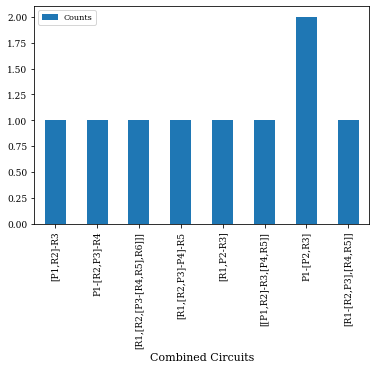

In [29]:
plt.figure(figsize=(10,5))
new_df.plot.bar(x="Combined Circuits",y="Counts")

### Quantify the complexity of each circuit

In [64]:
# calculate the numbers of each component and each symbols in the string
complexities = []

complexity_equs = []
complexity_numbers = []

complexity_components =[]
complexity_structures = []

complexity_ranks = []

for i in range(len(new_df['Combined Circuits'])):
    num_components = count_components(circuit = new_df['Combined Circuits'][i])

    complexity_component = np.sum(num_components[0][0:4])
    complexity_components.append(complexity_component)
    
    parallel_structures,lvl_counter_list = parallel_structure_identifior(input_circuit=new_df['Combined Circuits'][i],circuit_array=s_to_a_convert(new_df['Combined Circuits'][i]))
    complexity_structure = num_components[0][4]/2 + num_components[0][6] + np.sum(np.square(lvl_counter_list))
    complexity_structures.append(complexity_structure)
    
    complexity_equ = complexity_component - 1j*complexity_structure
    complexity_equs.append(complexity_equ)
    
    complexity_number = complexity_equ**2
    complexity_numbers.append(complexity_number)
    
    complexities.append([complexity_equ,complexity_number])
    
    complexity_rank = abs(complexity_number.real)
    complexity_ranks.append(complexity_rank)
    
new_df['Complexity'] = complexities

In [31]:
new_df

,Combined Circuits,Combined Values,Mathematical expressions,Counts,Complexity
0,"[P1,R2]-R3","[[P1w = 116.6632, P1n = 0.8429, R2 = 36.9393, ...",((X[0]*(2*np.pi*F)**(-X[1])*(np.cos((np.pi*X[1...,1,"[(3-3j), -18j]"
1,"P1-[R2,P3]-R4","[[P1w = 4.3371, P1n = 0.275, R2 = 30.6672, P3w...",X[0]*(2*np.pi*F)**(-X[1])*(np.cos((np.pi*X[1])...,1,"[(4-3j), (7-24j)]"
2,"[R1,[R2,[P3-[R4,R5],R6]]]","[[R1 = 7.39, R2 = 55.2413, P3w = 260.9053, P3n...",((X[0])**(-1)+(((X[1])**(-1)+(((X[2]*(2*np.pi*...,1,"[(6-24j), (-540-288j)]"
3,"[R1,[R2,P3]-P4]-R5","[[R1 = 35.9545, R2 = 1.0499, P3w = 59.9517, P3...",((X[0])**(-1)+(((X[1])**(-1)+(X[2]*(2*np.pi*F)...,1,"[(5-8j), (-39-80j)]"
4,"[R1,P2-R3]","[[R1 = 55.2413, P2w = 260.9053, P2n = 0.8429, ...",((X[0])**(-1)+(X[1]*(2*np.pi*F)**(-X[2])*(np.c...,1,"[(3-3j), -18j]"
5,"[[P1,R2]-R3,[P4,R5]]","[[P1w = 295.4727, P1n = 0.8753, R2 = 10.0, R3 ...",((((X[0]*(2*np.pi*F)**(-X[1])*(np.cos((np.pi*X...,1,"[(5-11j), (-96-110j)]"
6,"P1-[P2,R3]","[[P1n = 0.4029, P1w = 33.8628, P2n = 2.6748, P...",X[0]*(2*np.pi*F)**(-X[1])*(np.cos((np.pi*X[1])...,2,"[(3-3j), -18j]"
7,"[R1-[R2,P3],[R4,R5]]","[[R1 = 27.3698, R2 = 7.5264, P3w = 260.9053, P...",((X[0]+((X[1])**(-1)+(X[2]*(2*np.pi*F)**(-X[3]...,1,"[(5-11j), (-96-110j)]"


In [32]:
# rank the circuits with their complexities from low to high
new_df['Complexity_sort'] = complexity_ranks
new_df.sort_values(['Complexity_sort'],ascending=True,inplace=True)
new_df.drop(['Complexity_sort'],axis=1,inplace=True)
new_df.reset_index(drop=True,inplace=True)
new_df

,Combined Circuits,Combined Values,Mathematical expressions,Counts,Complexity
0,"[P1,R2]-R3","[[P1w = 116.6632, P1n = 0.8429, R2 = 36.9393, ...",((X[0]*(2*np.pi*F)**(-X[1])*(np.cos((np.pi*X[1...,1,"[(3-3j), -18j]"
1,"[R1,P2-R3]","[[R1 = 55.2413, P2w = 260.9053, P2n = 0.8429, ...",((X[0])**(-1)+(X[1]*(2*np.pi*F)**(-X[2])*(np.c...,1,"[(3-3j), -18j]"
2,"P1-[P2,R3]","[[P1n = 0.4029, P1w = 33.8628, P2n = 2.6748, P...",X[0]*(2*np.pi*F)**(-X[1])*(np.cos((np.pi*X[1])...,2,"[(3-3j), -18j]"
3,"P1-[R2,P3]-R4","[[P1w = 4.3371, P1n = 0.275, R2 = 30.6672, P3w...",X[0]*(2*np.pi*F)**(-X[1])*(np.cos((np.pi*X[1])...,1,"[(4-3j), (7-24j)]"
4,"[R1,[R2,P3]-P4]-R5","[[R1 = 35.9545, R2 = 1.0499, P3w = 59.9517, P3...",((X[0])**(-1)+(((X[1])**(-1)+(X[2]*(2*np.pi*F)...,1,"[(5-8j), (-39-80j)]"
5,"[[P1,R2]-R3,[P4,R5]]","[[P1w = 295.4727, P1n = 0.8753, R2 = 10.0, R3 ...",((((X[0]*(2*np.pi*F)**(-X[1])*(np.cos((np.pi*X...,1,"[(5-11j), (-96-110j)]"
6,"[R1-[R2,P3],[R4,R5]]","[[R1 = 27.3698, R2 = 7.5264, P3w = 260.9053, P...",((X[0]+((X[1])**(-1)+(X[2]*(2*np.pi*F)**(-X[3]...,1,"[(5-11j), (-96-110j)]"
7,"[R1,[R2,[P3-[R4,R5],R6]]]","[[R1 = 7.39, R2 = 55.2413, P3w = 260.9053, P3n...",((X[0])**(-1)+(((X[1])**(-1)+(((X[2]*(2*np.pi*...,1,"[(6-24j), (-540-288j)]"


In [33]:
new_df['Combined Circuits'][0]

'[P1,R2]-R3'

In [191]:
new_df['Combined Values'][0]

[['P1w = 116.6632', 'P1n = 0.8429', 'R2 = 36.9393', 'R3 = 18.3019']]

In [192]:
new_df['Mathematical expressions'][0]

'((X[0]*(2*np.pi*F)**(-X[1])*(np.cos((np.pi*X[1])*0.5)-np.sin((np.pi*X[1])*0.5)*1j))**(-1)+(X[2])**(-1))**(-1)+X[3]'

In [193]:
# original data
x_org,y_org
# simulated data
expression ---- (x_org,y_simulated)
#

NameError: name 'y' is not defined

In [ ]:
# 如何找到除了【】外的元素？？？

In [34]:
new_df['Combined Values'][0]

[['P1w = 116.6632', 'P1n = 0.8429', 'R2 = 36.9393', 'R3 = 18.3019']]

In [36]:
input_string = new_df['Mathematical expressions'][0]
input_string

'((X[0]*(2*np.pi*F)**(-X[1])*(np.cos((np.pi*X[1])*0.5)-np.sin((np.pi*X[1])*0.5)*1j))**(-1)+(X[2])**(-1))**(-1)+X[3]'

In [39]:
input_values = new_df['Combined Values'][0][0]
input_values

['P1w = 116.6632', 'P1n = 0.8429', 'R2 = 36.9393', 'R3 = 18.3019']

In [40]:
freq = np.array(frequencies)

In [41]:
# convert mathematical string into real mathematical expression
def convert_math(input_string = input_string, input_values = input_values, freq=freq):
    # 这里的data最后要改成跟上面处理完的data一样
    
    # create a list to store the value of each component
    values = []
    
    # define a pattern to find these values
    digit_p = re.compile(r'\-?[0-9]+\.[0-9]+')
    
    # search for these values and convert them to float
    for i in range(len(input_values)):
        combined_component_value = digit_p.findall(input_values[i])
        values.append(float(combined_component_value[0]))

    func_expression = eval(f'lambda X,F:{input_string}')
    
    X = values
    F = freq
    
    simulated_data = func_expression(X,F)
    return values,func_expression,simulated_data

In [42]:
values,func_expression,simulated_data = convert_math()

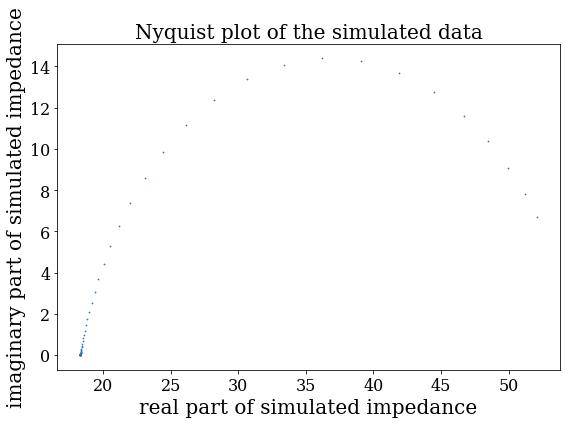

In [43]:
simulated_reals = simulated_data.real
simulated_imags = simulated_data.imag


fig = plt.figure(figsize=(9, 6))
sub0 = fig.add_subplot(111)
plt.scatter(simulated_reals,-simulated_imags,s=0.5) # note: np.cumsum also works
sub0.set_xlabel('real part of simulated impedance', fontsize=20)
sub0.set_ylabel('imaginary part of simulated impedance', fontsize=20)
sub0.set_title('Nyquist plot of the simulated data', fontsize=20)
# sub0.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.tick_params(labelsize=16)
plt.show()

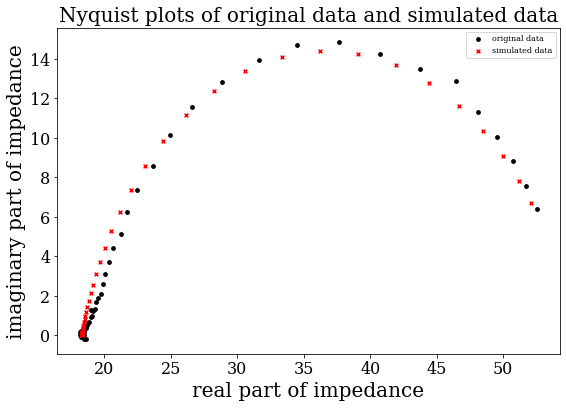

In [44]:
fig = plt.figure(figsize=(9, 6))
sub0 = fig.add_subplot(111)
plt.scatter(reals,imags,s=14,c='black',marker = "o",label = "original data") # note: np.cumsum also works
plt.scatter(simulated_reals,-simulated_imags,s=14,c='r',marker = "x",label="simulated data") # note: np.cumsum also works
sub0.set_xlabel('real part of impedance', fontsize=20)
sub0.set_ylabel('imaginary part of impedance', fontsize=20)
sub0.set_title('Nyquist plots of original data and simulated data', fontsize=20)
# sub0.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.tick_params(labelsize=16)
plt.legend()
plt.show()

## Bayesian Inference

In [40]:
import pymc3 as pm
import theano.tensor as tt
import arviz as az
import seaborn as sns

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [46]:
# initialize random seed generator
RANDOM_SEED = 10000
np.random.seed(RANDOM_SEED)

In [223]:
func_expression

<function __main__.<lambda>(X, F)>

In [232]:
def Bayesian_inference(original_data, simulated_parameters,simulated_expression):
    # load the inputs from original data (freq and impedance)
    
    df = pd.DataFrame(original_data)
    
    abs_Ewe = df["GEIS"]["Ewe_bar"]
    abs_I = df["GEIS"]["I_bar"]
    Phase_Zwe = np.array(df["GEIS"]["phase_Zwe"])
    
    abs_Z = np.divide(abs_Ewe, abs_I)
    Re_Z = np.multiply(abs_Z, (np.cos(Phase_Zwe)))
    Im_Z = np.multiply(abs_Z , (np.sin(Phase_Zwe)))

    reals = Re_Z
    imags = Im_Z
    freq = np.array(df["GEIS"]["freq"])
    measurements = reals + imags*1j
    
    X = []
    with pm.Model() as model:
        for i in range(len(simulated_parameters)):
            X.append(pm.Uniform(f"Parameter:{i}",simulated_parameters[i]*0.5,simulated_parameters[i]*2))
        y_calc = pm.Deterministic("y_calc",func_expression(X,freq))
        y_measured = measurements
        y_obs = pm.Normal("y_obs",mu=y_calc,sd=1,observed=y_measured)
    
        trace= pm.sample(draws=1000, chains=4, tune=1000, return_inferencedata=True)

    return trace

In [233]:
trace1 = Bayesian_inference(original_data = data,simulated_parameters=values,simulated_expression=func_expression)

TypeError: Casting from complex to real is ambiguous: consider real(), imag(), angle() or abs()

In [42]:
values = [116.6632, 0.8429, 36.9393, 18.3019]

In [44]:
func_expression = eval(f'lambda X,F: ((X[0]*(2*np.pi*F)**(-X[1])*(np.cos((np.pi*X[1])*0.5)-np.sin((np.pi*X[1])*0.5)*1j))**(-1)+(X[2])**(-1))**(-1)+X[3]')

In [47]:
X = []
with pm.Model() as model:
    for i in range(len(values)):
        X.append(pm.Uniform(f"Parameter:{i}",values[i]*0.5,values[i]*2))
    # y_calc = pm.Deterministic("y_calc",func_expression(X,freq))
    y_measured = measurements
    
    y_m_real = y_measured.real
    y_m_imag = y_measured.imag
    
    y_calc_real = func_expression(X,frequencies).real
    y_calc_imag = func_expression(X,frequencies).imag

    y_obs_Real = pm.Normal("y_obs_r",mu=y_calc_real,sd=1,observed=y_m_real)
    y_obs_Imag = pm.Normal("y_obs_i",mu=y_calc_imag,sd=1,observed=y_m_imag)

    trace1= pm.sample(draws=1000, chains=4, tune=1000, return_inferencedata=True)

WARNING (theano.tensor.opt): Optimization Warning: The Op real does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op inv does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op imag does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
D:\Anacoda\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)


TypeError: Elemwise{real,no_inplace}.grad illegally  returned an integer-valued variable. (Input index 0, dtype complex128)

In [53]:
np.asarray(y_calc_real)

array(Elemwise{real,no_inplace}.0, dtype=object)

In [58]:
y_calc_real.eval()

MissingInputError: Input 0 of the graph (indices start from 0), used to compute sigmoid(Parameter:3_interval__), was not provided and not given a value. Use the Theano flag exception_verbosity='high', for more information on this error.

In [ ]:
X = []
with pm.Model() as model:
    for i in range(len(values)):
        X.append(pm.Uniform(f"Parameter:{i}",values[i]*0.5,values[i]*2))
    y_calc = pm.Deterministic("y_calc",func_expression(X,freq))
    y_measured = measurements
    
    y_m_real = y_measured.real
    y_m_imag = y_measured.imag
    
    y_calc_real = y_calc.real
    y_calc_imag = y_calc.imag

    y_obs = pm.Normal("y_obs",mu=y_calc_real,sd=1,observed=y_m_real)

    trace2= pm.sample(draws=1000, chains=4, tune=1000, return_inferencedata=True)

In [57]:
y_calc

NameError: name 'y_calc' is not defined

In [ ]:
tensorflow
jpflow
stan

In [256]:
a = 'P1-[R2,C3]-R3-[R4,[P5-L6]]-R7'
b = '[R2,C3][R4,[P5-L6]]'

import difflib
d = difflib.Differ()
diff = d.compare(a.splitlines(),b.splitlines())
print('\n'.join(list(diff)))

- P1-[R2,C3]-R3-[R4,[P5-L6]]-R7
? ---       ----            ---

+ [R2,C3][R4,[P5-L6]]


In [42]:
new_df.to_csv('testcase.csv')

In [84]:
a = '[P1,R2]-R3'
b = re.compile(r'(?=(\[+(.*?)\]+))')
# print(re.sub('[^(?=(\[+(.*?)\]+))]','',a))
b.findall(a)

['[', ']']

## Visualization

## Store the results as .json